# Load Data and PKGs

## Pkgs

In [22]:
from os import getcwd as gwd
from os import chdir as cd
from itertools import combinations 
from scipy.stats import pearsonr as pr
from scipy.stats import zscore as zscore
from scipy.stats import ttest_rel as ttest
import copy
import numpy as np
import pandas
import matplotlib.pyplot as plt
np.random.seed(223)

In [24]:
# Replace outliers by mean
def clrOutlier(data):
    mu = np.mean(data,axis=None)
    sd = np.std(data,axis=None)
    ind1 = np.nonzero(data<float(mu-3*sd))
    if len(ind1) != 0:
        data[ind1] = mu
    ind2 = np.nonzero(data>float(mu+3*sd))
    if len(ind2) != 0:
        data[ind2] = mu
    return data

## Angular Error Data

In [46]:
angAnalysis = True
subjs = ['ZW','KP','JX','L']
dataAll = dict()
for subjName in subjs:
    data = pandas.read_csv((subjName+'.csv'),header=None,names=['x','y','ang'],usecols=[26,27,34])
    data = data[-pandas.isnull(data.x)]
    data = data[1:(len(data)+1)]
    data.index = range(len(data))
    data = data.astype(float)
    dataAll[subjName] = data

### Functions for Preprocessing

In [3]:
# calculate angular response
def calAng(x,y):
    angResp = np.rad2deg(np.arctan2(y,x))
    if angResp < 0:
        angResp = 360+angResp
    return angResp

# Morph errors
def morphErr(err):
    if err > 180:
        err = -360+err
    else:
        if err < (-180):
            err = 360+err
    return err

### Preprocessing

In [4]:
def preprocessPerSubj(data):
    angErr=None
    for trial in range(0,480):
        err = morphErr(calAng(data.x[trial],data.y[trial])-data.ang[trial]*7.5)
        if angErr is not None:
            angErr = np.vstack((angErr,np.array(err)))
        else:
            angErr = np.array(err)
    angErr = clrOutlier(angErr)
    return angErr

In [5]:
errAll = dict()
for subj in subjs:   
    errs = pandas.DataFrame(data = preprocessPerSubj(dataAll[subj]),columns=['errors'])
    errs['locs'] = dataAll[subj].ang
    errs = errs.sort_values('locs')
    errs.index = range(480)
    errAll[subj] = errs

## Reaction Time Data

In [26]:
rtAnalysis = True
subjs = ['ZW','KP','JX','L']
rtAll = dict()
for subjName in subjs:
    data = pandas.read_csv((subjName+'.csv'),header=None,names=['errors','locs'],usecols=[30,34]) # Note that now "errors" are rt
    data = data[-pandas.isnull(data.errors)]
    data = data[1:481]
    data = data.astype(float)
    data.errors = clrOutlier(np.array(data.errors))
    data = data.sort_values('locs')
    data.index = range(480)
    rtAll[subjName] = data

# Within-subject correlations

## functions

In [27]:
# generate random indices
def genRandInd():
    indices = None
    for angle in range(48):
        randInd = np.random.choice(10,5,replace=False)+angle*10
        if indices is not None:
            indices = np.hstack((indices,randInd))
        else:
            indices = randInd
    return np.array(indices)

# average each half
def avgHalf(df,indices):
    half1 = df.errors[indices]
    half2 = df.errors.drop(indices)
    resultDF = pandas.DataFrame()
    resultDF['half1'] = half1.groupby(np.arange(len(half1))//5).mean()
    resultDF['half2']  = half2.groupby(np.arange(len(half2))//5).mean()
    return resultDF

# shift a half for a random phase
# half must be a numpy array
def shiftHalf(half):
    randPhase = np.int(np.random.choice(len(half),1))
    if randPhase == 0:
        return half
    else:
        if randPhase == len(half)-1:
            half = np.concatenate(([half[randPhase]],half[range(randPhase)]))
            return half
        else:
            half = np.concatenate((half[range(randPhase,np.int(len(half)))],half[range(randPhase)]))
            return half

## Bootstrap Within

In [28]:
def avgSplitHalf(errAll,allSubj = subjs):
    allRVals = list()
    for subj in allSubj:
        twoHalves = avgHalf(errAll[subj],genRandInd())
        [r,p]=pr(twoHalves.half1,twoHalves.half2)
        allRVals.append(r)
    allRVals = np.array(allRVals)
    return np.tanh(np.mean(np.arctanh(allRVals)))

In [29]:
bootWithinR = list()
iters = 1000
for it in range(iters):
    if rtAnalysis:
        bootWithinR.append(avgSplitHalf(errAll = rtAll))
    else:
        bootWithinR.append(avgSplitHalf(errAll = errAll))

In [30]:
meanBootWithinR = np.tanh(np.mean(np.arctanh(bootWithinR)))
bootWithinCI = [np.sort(bootWithinR)[np.int(iters*.025-1)],np.sort(bootWithinR)[np.int(iters*.975-1)]]
print('Bootstrap Within Results')
print('mean r =',meanBootWithinR)
print('95% CI =','[',bootWithinCI[0],bootWithinCI[1],']')

Bootstrap Within Results
mean r = 0.29645980781649606
95% CI = [ 0.20837071534207718 0.38557921054747313 ]


## Permutation Within

In [31]:
def avgPermWithin(errAll,allSubj = subjs):
    permR = list()
    for subj in allSubj:
        twoHalves = avgHalf(errAll[subj],genRandInd())
        shiftedHalf = shiftHalf(np.array(twoHalves.half2))
        [r,p]=pr(twoHalves.half1,shiftedHalf)
        permR.append(r)
    permR = np.array(permR)
    return np.tanh(np.mean(np.arctanh(permR)))

In [32]:
permWithinR = list()
iters = 1000
for it in range(iters):
    if rtAnalysis:
        permWithinR.append(avgPermWithin(rtAll))
    else:
        permWithinR.append(avgPermWithin(errAll))

In [33]:
meanPermWithinR = np.tanh(np.mean(np.arctanh(permWithinR)))
permWithinCI = [np.sort(permWithinR)[np.int(iters*.025-1)],np.sort(permWithinR)[np.int(iters*.975-1)]]
print('Permutation Within Results')
print('mean r =',meanPermWithinR)
print('95% CI =','[',permWithinCI[0],permWithinCI[1],']')

Permutation Within Results
mean r = -0.001566255148006789
95% CI = [ -0.22214384764281744 0.22943904053272474 ]


## Correlate angular errors in face with NB

In [13]:
nbData = pandas.read_csv('/Users/zixuan/Box/Position ZW/diffEcc/NoiseBlob/Results/ZWmean.csv',header=None,names=['errors'])
faceData = errAll['ZW'].errors.groupby(np.arange(len(errAll['ZW'].errors))//10).mean()
nbData = nbData.errors[np.hstack((47,np.arange(47)))]
[r,p] = pr(faceData,nbData)
print(r,p)

0.42019440103001116 0.002944847805601079


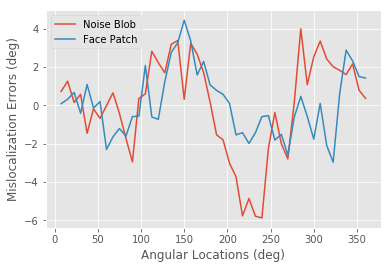

In [28]:
plt.plot(7.5*np.arange(1,49),nbData)
plt.plot(7.5*np.arange(1,49),faceData)
plt.legend(['Noise Blob','Face Patch'])
plt.xlabel("Angular Locations (deg)")
plt.ylabel("Mislocalization Errors (deg)")
plt.savefig("corrFaceNB.png")
plt.show()

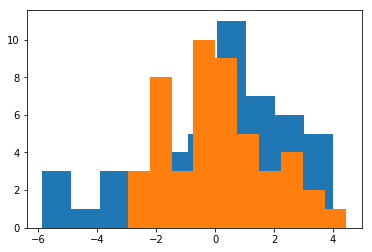

In [15]:
plt.hist(nbData)
plt.hist(faceData)
plt.show()

# Between-subject correlations

## functions

In [34]:
# correlate 2 halves from 2 subjects
def corrEachPair(errs1,errs2,permOrNot=False):
    twoHalves1 = avgHalf(errs1,genRandInd())
    twoHalves2 = avgHalf(errs2,genRandInd())
    anotherHalf = twoHalves2.half1
    if permOrNot:
        twoHalves2.half1 = shiftHalf(np.array(anotherHalf))
    [r,p]=pr(twoHalves1.half1,anotherHalf)        
    return r

# all pairwise between
def pairwiseBtw(errAll,subjName=subjs,perm=False):
    allRVals = list()
    for subj1 in subjName:
        for subj2 in subjName:
            if subj1 != subj2:
                r=corrEachPair(errAll[subj1],errAll[subj2],perm)
                allRVals.append(r)
    return(np.array(allRVals))


## Bootstrap Between

In [37]:
iters = 1000
bootBtwR = list()
for it in range(iters):
    if rtAnalysis:
        bootBtwR.append(np.tanh(np.mean(np.arctanh(pairwiseBtw(rtAll)))))
    else:
        bootBtwR.append(np.tanh(np.mean(np.arctanh(pairwiseBtw(errAll)))))
bootBtwR = np.array(bootBtwR)

In [38]:
meanBootBtwR = np.tanh(np.mean(np.arctanh(bootBtwR)))
bootBtwCI = [np.sort(bootBtwR)[np.int(iters*0.025-1)],np.sort(bootBtwR)[np.int(iters*0.975-1)]]
print('Bootstrap Between-subject Results')
print('mean r =',meanBootBtwR)
print('95% CI =','[',bootBtwCI[0],bootBtwCI[1],']')

Bootstrap Between-subject Results
mean r = 0.021732405960518945
95% CI = [ -0.04714185072759388 0.084808959829476 ]


## Permutation Between

In [39]:
iters = 1000
permBtwR = list()
for it in range(iters):
    if rtAnalysis:
        permBtwR.append(np.tanh(np.mean(np.arctanh(pairwiseBtw(rtAll,perm=True)))))
    else:
        permBtwR.append(np.tanh(np.mean(np.arctanh(pairwiseBtw(errAll,perm=True)))))
permBtwR = np.array(permBtwR)

In [40]:
meanPermBtwR = np.tanh(np.mean(np.arctanh(permBtwR)))
permBtwCI = [np.sort(permBtwR)[np.int(iters*0.025-1)],np.sort(permBtwR)[np.int(iters*0.975-1)]]
print('Permutation Between-subject Results')
print('mean r =',meanPermBtwR)
print('95% CI =','[',permBtwCI[0],permBtwCI[1],']')

Permutation Between-subject Results
mean r = -0.0022005505585354374
95% CI = [ -0.10809193543627733 0.10434108757627049 ]


## Ploting Within vs. Between

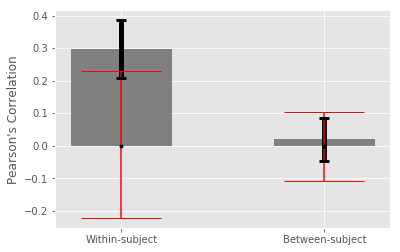

In [42]:
plt.style.use('ggplot')
x = ['Within-subject','Between-subject']
meanRs = [meanBootWithinR,meanBootBtwR]
CIs = np.array([[meanBootWithinR-bootWithinCI[0],meanBootBtwR-bootBtwCI[0]], \
               [bootWithinCI[1]-meanBootWithinR,bootBtwCI[1]-meanBootBtwR]])
barWidth = .3
x_pos = [0,barWidth*2]
plt.bar(x_pos, meanRs, color='gray',yerr=CIs,width=barWidth,error_kw=dict(lw=5, capsize=5, capthick=3))
plt.xticks(x_pos, x)

plt.errorbar([0,2*barWidth],[0,0],[[-permWithinCI[0],-permBtwCI[0]],\
                                   [permWithinCI[1],permBtwCI[1]]],fmt='.k',\
             capsize=40,ecolor='red')
plt.ylabel("Pearson's Correlation")
if rtAnalysis:
    plt.savefig("WithinBetweenCorrRT.png")
else:
    plt.savefig("WithinBetweenCorr.png")
# # plot perm CIs as horizontal bars
# plt.plot([-barWidth/2,barWidth/2],[permWithinCI[0],permWithinCI[0]],color = 'red')
# plt.plot([-barWidth/2,barWidth/2],[permWithinCI[1],permWithinCI[1]],color = 'red')
# plt.plot([3*barWidth/2,5*barWidth/2],[permBtwCI[0],permBtwCI[0]],color = 'blue')
# plt.plot([3*barWidth/2,5*barWidth/2],[permBtwCI[1],permBtwCI[1]],color = 'blue')